In [1]:
%load_ext autotime

## Build Reference PSC

In [2]:
import os
import numpy as np
import pandas as pd
from copy import copy

from glob import glob

from matplotlib import pyplot as plt
plt.style.use('bmh')
from IPython import display

from astropy.time import Time
from astropy.stats import sigma_clip

from piaa.exoplanets import Exoplanet
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils import pipeline

time: 6.16 s


In [3]:
fields_dir = os.path.join(os.environ['PANDIR'], 'images', 'fields')

time: 1.26 ms


In [4]:
# unit_id = 'PAN001'
# field_id = 'Wasp50'
# cam_id = '14d3bd'
# seq_id = '20181215T050712'
unit_id = 'PAN012'
field_id = 'Hd189733'
cam_id = '358d0f'
seq_id = '20180822T035809'

sequence = '_'.join([unit_id, cam_id, seq_id])
sequence

'PAN012_358d0f_20180822T035809'

time: 17.4 ms


In [5]:
base_dir = os.path.join(fields_dir, unit_id, field_id, cam_id, seq_id)

base_dir

'/var/panoptes/images/fields/PAN012/Hd189733/358d0f/20180822T035809'

time: 5.88 ms


In [6]:
ticid = 256364928  # HD 189733
# ticid = 11036706
# ticid = 11133818  # Ugly PSF
# ticid = 388448267 # Ugly PSF

# ticid = 417898196
# ticid = 382391899  # Wasp 50
ticid = 11027938

time: 1.07 ms


In [7]:
stamp_book_size = 200

time: 847 µs


In [8]:
# Get the list of similar stars. The picid at index 0 is the target star
collection_fn = os.path.join(base_dir, 'vary-{}.csv'.format(ticid))
vary_list = pd.read_csv(collection_fn, names=['picid', 'v'])

time: 31.7 ms


In [9]:
vary_list.head()

,picid,v
0,11027938,0.000000
1,451931441,0.059619
2,12203933,0.074437
3,115999783,0.094620
4,116692143,0.100182


time: 15.5 ms


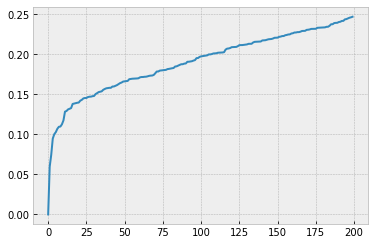

time: 475 ms


In [10]:
plt.plot(vary_list.iloc[:stamp_book_size].v)

### Get stamp collection

Build up a stamp book of the target star and the top references.

In [11]:
stamp_files = glob(os.path.join(base_dir, 'stamps', '*.csv'))

time: 12.6 ms


In [12]:
ref_list = list(vary_list.picid[:stamp_book_size].values)

time: 3.82 ms


In [13]:
camera_bias = 2048

time: 4.01 ms


In [14]:
# Slice frames
# Empirically based
frame_slice = slice(0, -1)

time: 962 µs


In [15]:
filter_time = '2018-08-22 07:15:00'

time: 868 µs


In [16]:
stamp_collection = list()

for i, picid in enumerate(ref_list):
    stamp_fn = os.path.join(base_dir, 'stamps', f'{picid}.csv')
    full_ref_table = pd.read_csv(stamp_fn).set_index(['obs_time', 'picid'])
    ref_table = full_ref_table.query(f"obs_time <= '{filter_time}'")

    ref_psc = np.array(ref_table) - camera_bias
    stamp_collection.append(ref_psc)
    
stamp_collection = np.array(stamp_collection)

stamp_collection = stamp_collection[:, frame_slice, :]
image_times = pd.to_datetime(ref_table.index.levels[0].values)[frame_slice]

stamp_collection.shape

(200, 108, 100)

time: 6.06 s


In [17]:
# Get target PSC (may have changed with frame_slice)
target_psc = stamp_collection[0]

num_frames = stamp_collection.shape[1]
num_frames

108

time: 10.3 ms


In [18]:
num_refs = 100

time: 929 µs


In [19]:
# Get a normalized version of the entire stamp collection
normalized_collection = np.array([pipeline.normalize(s) for s in stamp_collection[:num_refs]])
normalized_collection.shape

(100, 108, 100)

time: 45.6 ms


### Build coeffecients

In [20]:
# Get the coefficients the most optimally combine the normalized referenes into 
# one single master reference.
coeffs = pipeline.get_ideal_full_coeffs(normalized_collection)

time: 180 ms


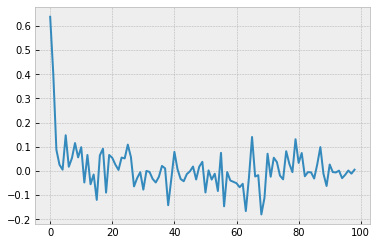

time: 331 ms


In [21]:
plt.plot(coeffs[0])

### Build reference PSC

In [22]:
# Use the coeffecients generated from the normalized references and
# apply them to the non-normalized (i.e. flux) stamps
ideal_psc = pipeline.get_ideal_full_psc(
    stamp_collection[:num_refs], 
    coeffs[0]
).reshape(num_frames, -1)
ideal_psc.shape

(108, 100)

time: 16.6 ms


5 5 G1


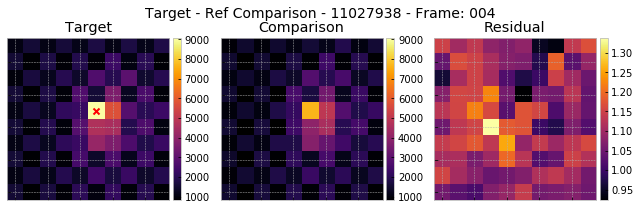

time: 1.69 s


In [23]:
stamp_side = int(np.sqrt(target_psc.shape[1]))

frame_idx = 4

# Reshape into square stamps and plot the requested frame
stamp_fig = plot.show_stamps([
    target_psc.reshape(num_frames, stamp_side, stamp_side), 
    ideal_psc.reshape(num_frames, stamp_side, stamp_side)
], frame_idx=frame_idx, show_residual=True, stretch='linear')

stamp_fig.set_size_inches(9, 3.1)

stamp_fig.suptitle(f'Target - Ref Comparison - {ticid} - Frame: {frame_idx:03d}', 
                   y=1.0, fontsize=14)

# Mask the brightest pixel
t0 = target_psc[frame_idx].reshape(stamp_side, stamp_side)
y_pos, x_pos = np.argwhere(t0 == t0.max())[0]
center_color = helpers.pixel_color(x_pos, y_pos)
print(x_pos, y_pos, center_color)
stamp_fig.axes[0].scatter(x_pos, y_pos, marker='x', color='r')

stamp_fig.tight_layout()
target_ref_comp_fn = os.path.join(base_dir, f'ref-comparison-{ticid}-{frame_idx:03d}.png')
stamp_fig.savefig(target_ref_comp_fn, dpi=150)

display.display(stamp_fig)

### Aperture photometry

In [24]:
aperture_size = 5

time: 897 µs


In [25]:
lc0 = pipeline.get_aperture_sums(
    target_psc, 
    ideal_psc, 
    image_times,
    aperture_size=aperture_size, 
#     plot_apertures=True,
    aperture_fn=os.path.join(base_dir, 'apertures', f'{ticid}')
)

time: 322 ms


In [26]:
# Save the lightcurve dataframe to a csv file
# NOTE: We do this before normalizing
csv_file = os.path.join(base_dir, '{}_{}_lc.csv'.format(
    sequence.replace('/', '_'), 
    ticid
))

# Save before adding relative flux
lc0.to_csv(csv_file)

time: 8.59 ms


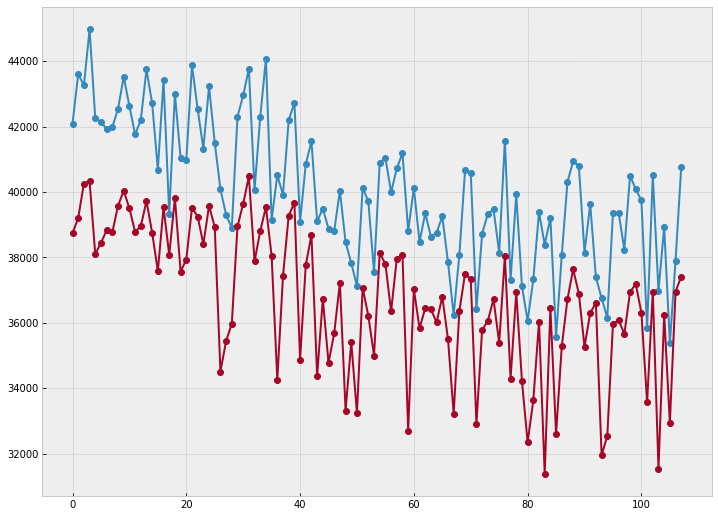

time: 855 ms


In [27]:
plt.figure(figsize=(12, 9))
plt.plot(lc0.loc[lc0.color == 'g'].target.values, marker='o') #.plot(marker='o')
plt.plot(lc0.loc[lc0.color == 'g'].reference.values, marker='o') #.plot(marker='o')

In [28]:
# Make a copy
lc1 = lc0.copy()

time: 1.59 ms


In [29]:
for field in ['reference', 'target']:
    color_normer = lc0.groupby('color')[field].apply(lambda x: np.mean(x))

    for color, normalizer in color_normer.iteritems():
        print(f"{field} {color} μ={normalizer:.04f}")

        # Get the raw values
        raw_values = lc1.loc[lc1.color == color, (field)]

        lc1.loc[lc1.color == color, (f'{field}')] = raw_values / normalizer

reference b μ=10624.0333
reference g μ=36756.8502
reference r μ=13124.3579
target b μ=11460.9630
target g μ=40053.1019
target r μ=14916.9722
time: 81.1 ms


In [30]:
lc1.head()

,color,reference,target
obstime,,,
2018-08-22 04:00:12,r,1.100488,1.066570
2018-08-22 04:00:12,g,1.054050,1.050880
2018-08-22 04:00:12,b,1.028272,1.074517
2018-08-22 04:02:02,r,1.132540,1.216534
2018-08-22 04:02:02,g,1.066609,1.088854


time: 20.7 ms


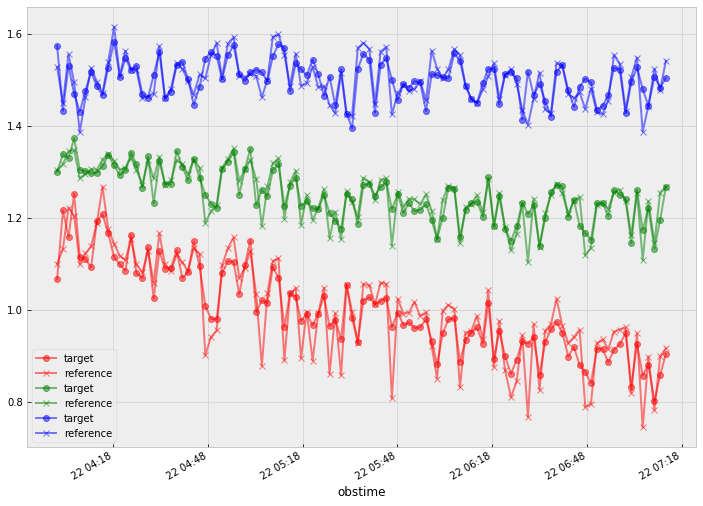

time: 905 ms


In [31]:
plt.figure(figsize=(12, 9))
i = 0
for color in 'rgb':
    (lc1.loc[lc1.color == color].target + i).plot(marker='o', color=color, alpha=0.5)
    (lc1.loc[lc1.color == color].reference + i).plot(marker='x', color=color, alpha=0.5)
    i += 0.25

plt.legend()

In [32]:
ingress = Time('2018-08-22 04:53:00').datetime
midpoint = Time('2018-08-22 05:47:00').datetime
egress = Time('2018-08-22 06:41:00').datetime

time: 6.03 ms


σ=1.8411%


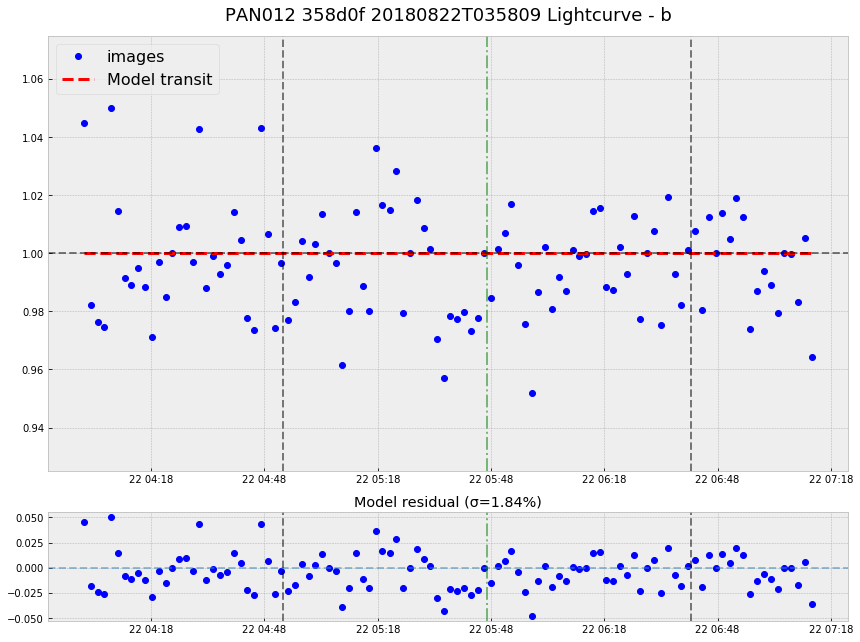

σ=1.2636%


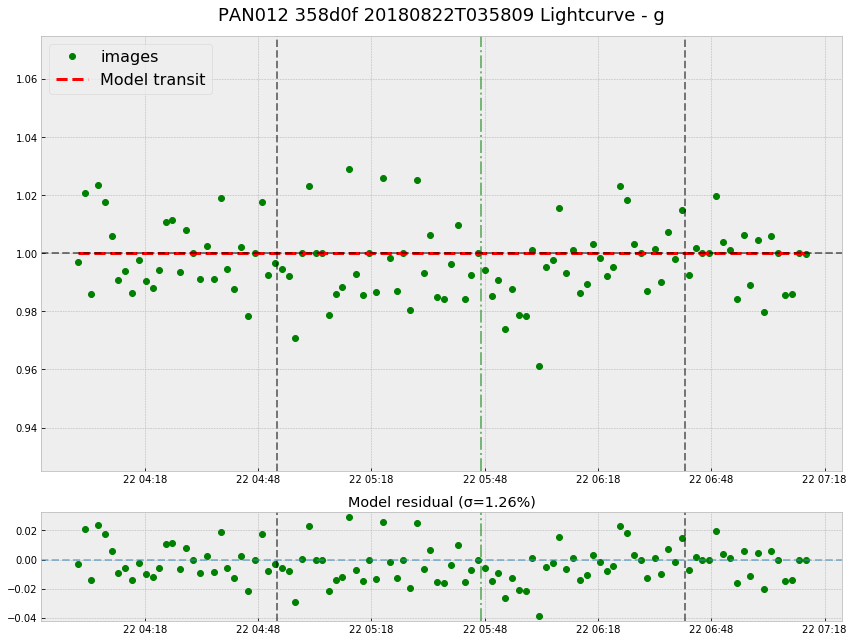

σ=2.5886%


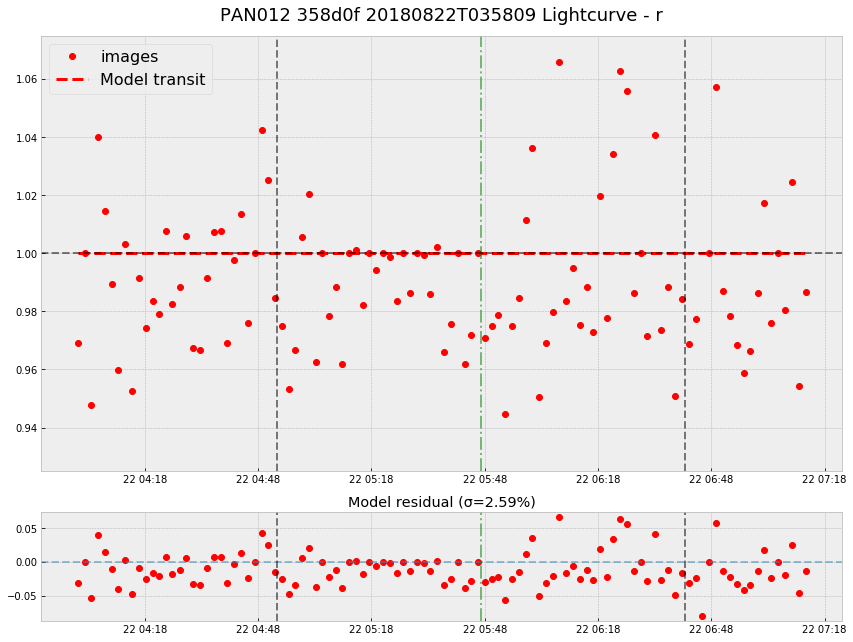

time: 3.28 s


In [33]:
x = lc1.index.unique()

for color, data in lc1.groupby('color'):
    
    y = pd.Series(sigma_clip(data.target / data.reference).filled(1), index=x)
    
    base_model_flux = np.ones_like(y)
    
    lc_fig = plot.plot_lightcurve(x, y, base_model_flux, 
        transit_info=[midpoint, ingress, egress],
        title="{} Lightcurve - {}".format(sequence.replace('_', ' '), color),
        ylim=[.9, 1.1], 
        color=color
    )    
    lc_fig.get_axes()[0].set_ylim([0.925, 1.075])
    
    print('σ={:.04%}'.format(y.std()))
       
    display.display(lc_fig)

### Examine

In [34]:
# Detrend by the median value
t0 = target_psc.sum(1) / np.mean(target_psc.sum(1))
i0 = ideal_psc.sum(1) / np.mean(ideal_psc.sum(1))

time: 2.58 ms


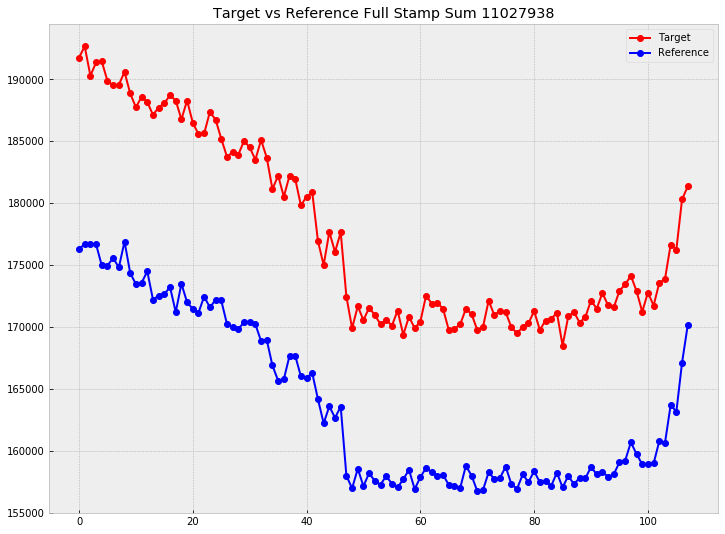

time: 412 ms


In [36]:
plt.figure(figsize=(12, 9))
plt.plot(target_psc.sum(1), marker='o', c='r', label='Target')
plt.plot(ideal_psc.sum(1), marker='o', c='b', label='Reference')

# plt.axvline(midpoint, label='mid-transit', ls='-.', c='g')
# plt.axvline(ingress, label='ingress', ls='--')
# plt.axvline(egress, label='egress', ls='--')

plt.title(f'Target vs Reference Full Stamp Sum {ticid}')
plt.legend()